In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import SobolIndices, ShapleyIndices
from shapley import KrigingModel, RandomForestModel
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
compute_score = False
ylim = [-0.1, 1.]

In [2]:
mu_betas = [247, 218, 148, 105]
sigma_betas = [6, 5, 4, 3]
mu_normal = [35, 18, 14, 11, 8, 1, -31]
sigma_normal = [5, 5, 5, 5, 5, 5, 5]
bounds_low = [235, 207, 141, 100]
bounds_up = [259, 229, 155, 110]

margins = []
for mu, sigma, a, b in zip(mu_betas, sigma_betas, bounds_low, bounds_up):
    dist = ot.Beta()
    dist.setParameter(ot.BetaMuSigma()([mu, sigma, a, b]))
    margins.append(dist)
    
for mu, sigma in zip(mu_normal, sigma_normal):
    margins.append(ot.Normal(mu, sigma))
    
mu = np.asarray(mu_betas + mu_normal)
sigma = np.asarray(sigma_betas + sigma_normal)
dim = len(mu)

In [3]:
correlation = ot.CorrelationMatrix(pd.read_csv('./data/correlation.csv', sep=',', header=None).values)
copula = ot.NormalCopula(correlation)
input_distribution = ot.ComposedDistribution(margins, copula)

In [4]:
if False:
    dist_sample = pd.DataFrame(np.asarray(input_distribution.getSample(100)))
    sns.pairplot(dist_sample)

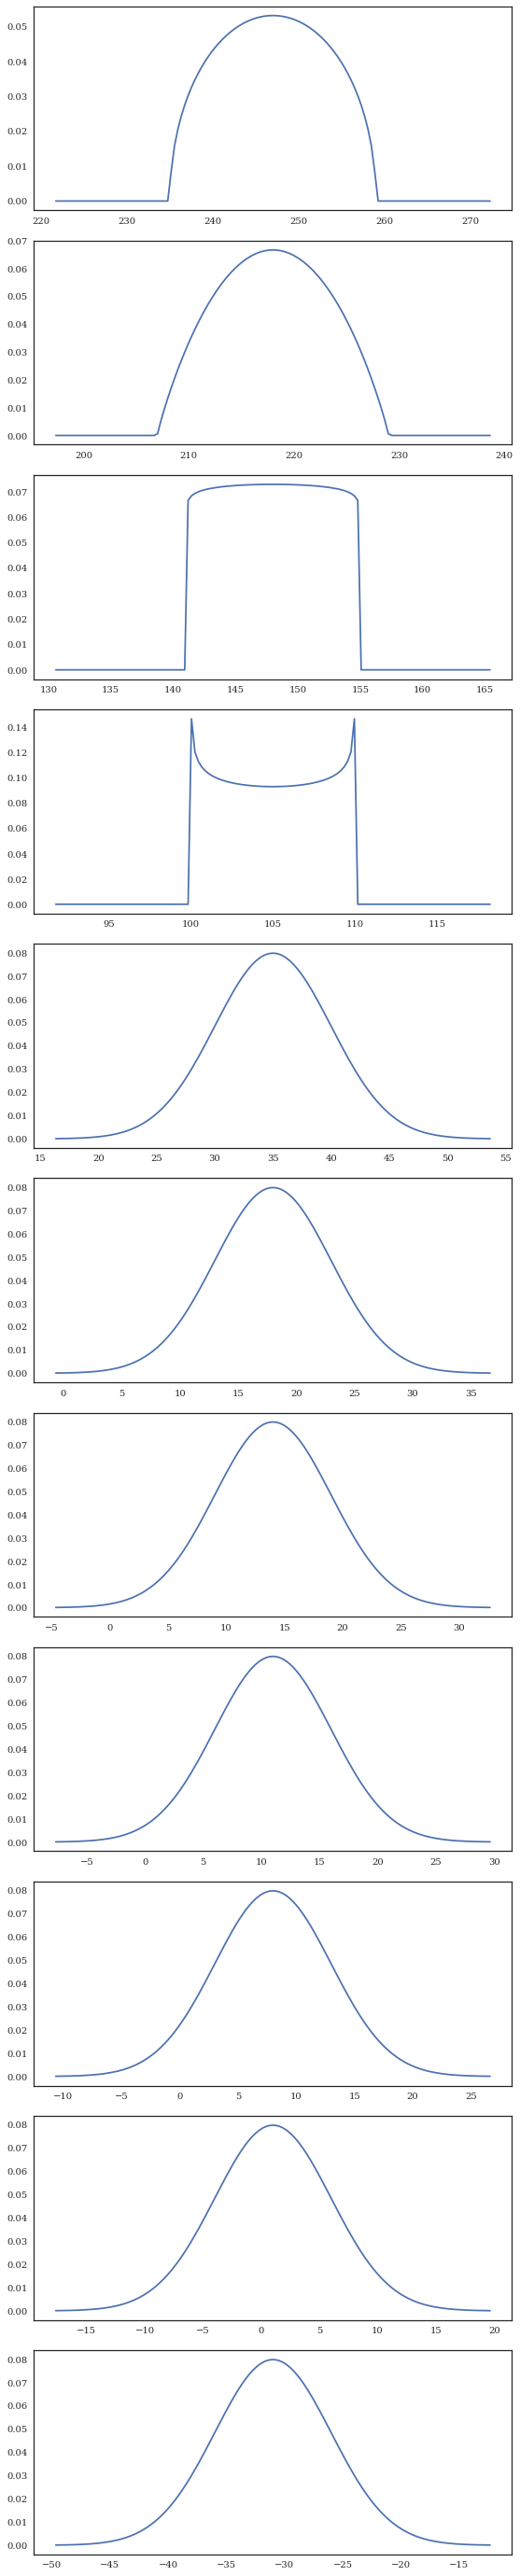

In [5]:
fig, axes = plt.subplots(dim, 1, figsize=(8, dim*3.5))
for i, marginal in enumerate(margins):
    ax = axes[i]
    tmp = np.asarray(marginal.drawPDF().getDrawable(0).getData())
    x_plot, y_plot = tmp[:, 0], tmp[:, 1]
    ax.plot(x_plot, y_plot)
    ax.axis('tight')
fig.tight_layout()

In [6]:
from sklearn import preprocessing
data = pd.read_csv('./data/results_unif.txt', sep=' ', header=None, usecols=range(dim+1))
X = data.values[:, :dim]
y = data.values[:, 11]
X[:, :4] /= 1.E9
y = preprocessing.scale(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
from sklearn.metrics import r2_score
library = 'gpflow'
basis = 'linear'
kernel = 'RBF'

test_model_gp = KrigingModel(model=lambda x: None, input_distribution=input_distribution)
test_model_gp.input_sample = X_train
test_model_gp.output_sample = y_train
test_model_gp.build(library=library, basis_type=basis, kernel=kernel)

y_pred = test_model_gp.predict(X_test)
print('R2:', r2_score(y_test, y_pred))

('R2:', 0.052997275141365208)


In [9]:
if compute_score:
    score_q2_loo = meta_model.compute_score_q2_loo()
    print('Leave One Out Q2 score:', score_q2_loo)

In [10]:
model_gp= KrigingModel(model=lambda x: None, input_distribution=input_distribution)
model_gp.input_sample = X
model_gp.output_sample = y
model_gp.build(library=library, basis_type=basis, kernel=kernel)

In [11]:
n_perms = 100
n_var = 1000
n_outer = 1
n_inner = 3
budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

('Max budget:', 4000)


In [12]:
%%time 
n_realization = 200
shapley_gp = ShapleyIndices(input_distribution)
shapley_gp.build_sample(model=model_gp, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

CPU times: user 21.7 s, sys: 32.6 s, total: 54.2 s
Wall time: 10.6 s


In [13]:
%%time
n_boot = 1
result_shapley_gp = shapley_gp.compute_indices(n_boot=n_boot)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 36 ms


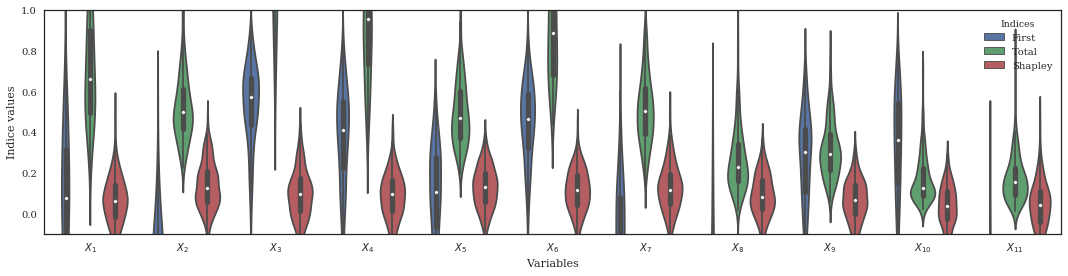

In [14]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_sensitivity_results(result_shapley_gp, indice='all', ax=ax)
ax.set_ylim(ylim)
fig.tight_layout()

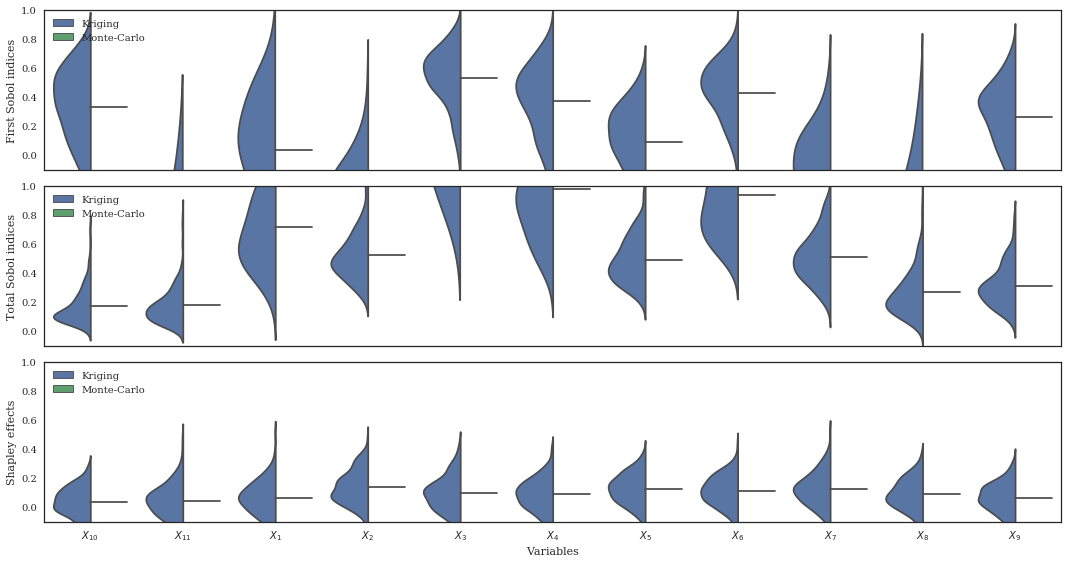

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(result_shapley_gp, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(result_shapley_gp, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(result_shapley_gp, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()

In [48]:
n_iter_search = 0
test_model_rf = RandomForestModel(model=lambda x: None, input_distribution=input_distribution)
test_model_rf.input_sample = X_train
test_model_rf.output_sample = y_train
test_model_rf.build(n_estimators=n_realization, n_iter_search=n_iter_search)

y_pred = test_model_rf.predict(X_test)
print('R2:', r2_score(y_test, y_pred))

('R2:', 0.28810843173269618)


In [16]:
model_rf = RandomForestModel(model=lambda x: None, input_distribution=input_distribution)
model_rf.input_sample = X
model_rf.output_sample = y
model_rf.build(n_estimators=n_realization)

In [30]:
n_perms = 5000
n_var = 1000
n_outer = 1
n_inner = 5
budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

('Max budget:', 251000)


In [26]:
%%time 
shapley_rf = ShapleyIndices(input_distribution)
shapley_rf.build_sample(model=model_rf, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

CPU times: user 10min 39s, sys: 24min 39s, total: 35min 19s
Wall time: 4min 34s


In [27]:
%%time
n_boot = 1
result_shapley_rf = shapley_rf.compute_indices(n_boot=n_boot)

CPU times: user 672 ms, sys: 360 ms, total: 1.03 s
Wall time: 1.03 s


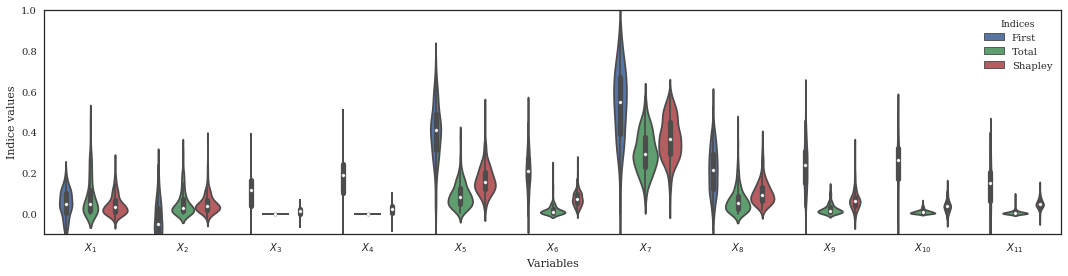

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))
plot_sensitivity_results(result_shapley_rf, indice='all', ax=ax)
ax.set_ylim(ylim)
fig.tight_layout()

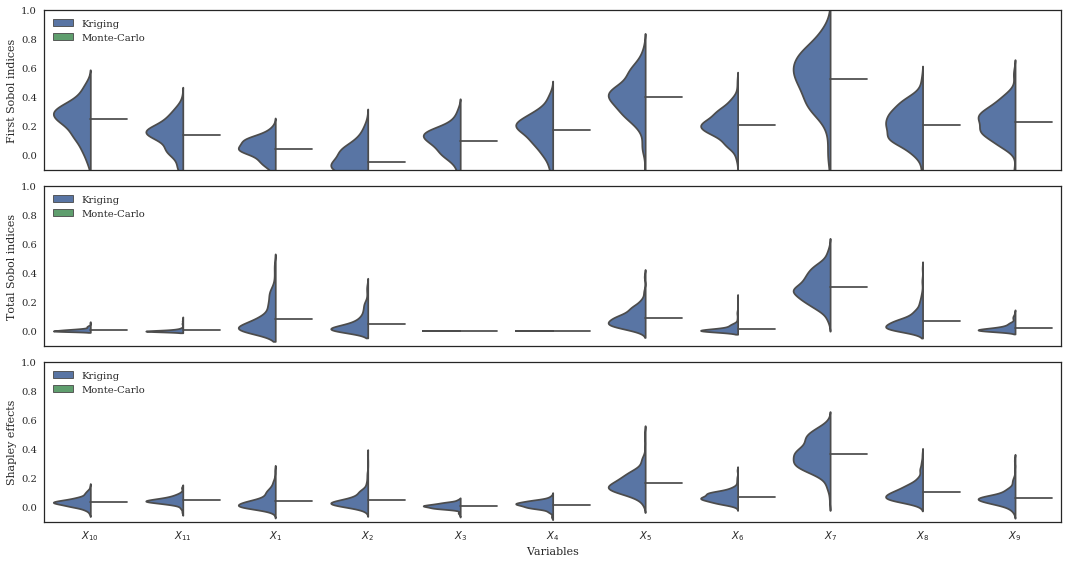

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(result_shapley_rf, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(result_shapley_rf, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(result_shapley_rf, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()